In [1]:
### import dependencies

import numpy as np
import os
import errno                #error symbols
import argparse             #command line input parsing
import sys
import json
import datetime
import numpy as np
import skimage.io
import cv2
import skimage.external.tifffile as tiff

from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K
from scipy import stats


from scipy.ndimage.measurements import label
ROOT_DIR = os.path.abspath("../")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn.deepcell_config import CellConfig
from mrcnn.deepcell_dataset import CellDataset
from mrcnn.deepcell_inference import InferenceConfig
from mrcnn.deepcell_inferenceLarge import InferenceConfigLarge
from mrcnn import deepcell_traintest
from mrcnn import utils
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings("ignore")

from deepcell import get_image_sizes
from deepcell import make_training_data
from deepcell import bn_feature_net_31x31
from deepcell import dilated_bn_feature_net_31x31
from deepcell import bn_feature_net_61x61           #model_zoo
from deepcell import dilated_bn_feature_net_61x61
from deepcell import train_model_watershed
from deepcell import train_model_watershed_sample
from deepcell import bn_dense_feature_net
from deepcell import rate_scheduler
from deepcell import train_model_disc, train_model_conv, train_model_sample
from deepcell import run_models_on_directory
from deepcell import export_model
from deepcell import get_data



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Set global variables and define model initiation func

TRAIN_DIR = '/Mask_RCNN/data/raw_train'
VAL_DIR = '/Mask_RCNN/data/raw_train'
MASK_DIR = '/Mask_RCNN/data/annotated'
MODEL_DIR = '/Mask_RCNN/models'
OUTPUT_DIR = '/Mask_RCNN/output'
#WEIGHTS_PATH = '/Mask_RCNN/models/cell20180820T2158/mask_rcnn_cell_0060.h5'
#WEIGHTS_PATH = '/Mask_RCNN/models/cell_trained_fullset_newdat/mask_rcnn_cell_0100.h5'
WEIGHTS_PATH = '/Mask_RCNN/models/cell20180822T0142/mask_rcnn_cell_0069.h5'

OUTPUT_DATATYPE = 'float16'
OUTPUT_MASK_TYPE = 'uint16'

N_EPOCHS = 100
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

COCO_MODEL_PATH = './mask_rcnn_coco.h5'

TEST_IMAGE_1 = 'crop0_dsDNA3.tif'
TEST_IMAGE_2 = 'crop14_dsDNA1.tif'

config = CellConfig()
config.display()


def init_model():
    # Download COCO trained weights from Releases if needed
#    if not os.path.exists(COCO_MODEL_PATH):
#        utils.download_trained_weights(COCO_MODEL_PATH)

    #load COCO trained weights
#    model.load_weights(COCO_MODEL_PATH, by_name=True,
#                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
#                                "mrcnn_bbox", "mrcnn_mask"])

    model.load_weights(WEIGHTS_PATH)



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        1000
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                2
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               700
MEAN_PIXEL                     [43.53 39.56 48.22]
MINI_M

In [3]:
### Create and train model

#Create model
#model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
#init_model()

#train model
#deepcell_traintest.train_model_withvalidation(model, TRAIN_DIR, VAL_DIR, nepoch=N_EPOCHS)


In [4]:
### Create inference model and run it on single image

#recreate model in inference mode
inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode='inference',
                            config=inference_config,
                            model_dir=MODEL_DIR)

#load weights
model_path = WEIGHTS_PATH
assert model_path != "", "Provide path to trained weights(The .h5 files)"
print("Loading weights from: ", model_path)
model.load_weights(model_path, by_name=True)

test_image_path = os.path.join(VAL_DIR, TEST_IMAGE_2)
#        image = deepcell_traintest.autotest(test_image_path)
#        images = deepcell_traintest.test(model, VAL_DIR, model_path=WEIGHTS_PATH)

frame=skimage.io.imread(test_image_path)

results = model.detect([frame], verbose=1)
r = results[0]
print('Mask shape is: ', r['masks'].shape)        

Loading weights from:  /Mask_RCNN/models/cell20180822T0142/mask_rcnn_cell_0069.h5
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  100.00000  uint16
molded_images            shape: (1, 1024, 1024, 3)    min:  -48.22000  max:   60.44000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
Mask shape is:  (512, 512, 537)


(512, 512, 3)
(512, 512, 3)


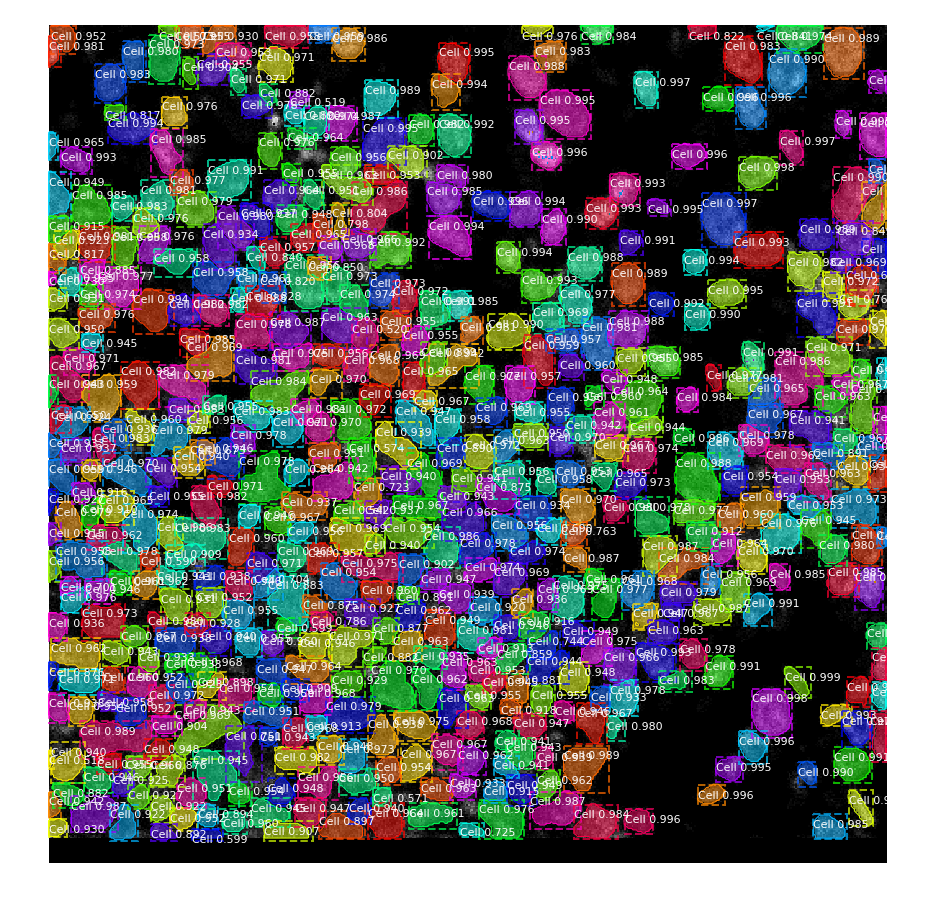

In [5]:
### Visualize masks and bounding boxes overlaid on raw dsDNA

dsDNA = np.copy(frame[:,:,0])
dsDNA = dsDNA*7

dsDNA = np.expand_dims(dsDNA, axis=-1)
dsDNA_frame = np.copy(dsDNA)
        
dsDNA = np.dstack((dsDNA, dsDNA_frame))
dsDNA = np.dstack((dsDNA, dsDNA_frame))
#if input is grayscale, uncomment this line
#frame=np.expand_dims(frame, axis=-1)
print(dsDNA.shape)
print(frame.shape)

class_names = ['BG', 'Cell']
visualize.display_instances(dsDNA, r['rois'], r['masks'],
                                    r['class_ids'], class_names, r['scores'])

In [6]:
print('shape of rois is:', r['rois'].shape)
print('shape of masks is:', r['masks'].shape)
print('shape of class_ids is:', r['class_ids'].shape)
print('shape of scores is:', r['scores'].shape)

shape of rois is: (537, 4)
shape of masks is: (512, 512, 537)
shape of class_ids is: (537,)
shape of scores is: (537,)


bool


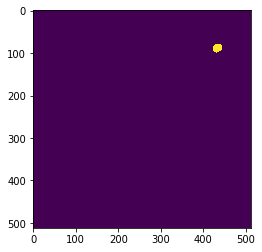

In [9]:
print(r['masks'].dtype)
import matplotlib.pyplot as plt

plt.imshow(r['masks'][:,:,2])

In [17]:
print(np.size(r['masks'][:,:,2]))
print(r['masks'][:,:,2].max())
print(r['masks'][:,:,2].dtype)

262144
True
bool


In [10]:
image = np.zeros((512,512))

num_mask_index = 2

for x in range(0, np.size(r['masks'], num_mask_index)):
    #print(x)
    
    
    
    image[r['masks'][:,:,x] == 1 ] = (x+1)
    
    

In [ ]:
def to_binary(img, lower, upper):
    return (lower < img) & (img < upper)

cleared = to_binary(image, 1, 500)
cleared = clear_border(cleared)

image = image*cleared

plt.imshow(image)

print(cleared.sum())
print(image.sum())

In [ ]:
### Testing garbage


#output = deepcell_traintest.display_instances(frame, r['rois'], r['masks'],
#                                          r['class_ids'], class_names, r['scores'])
#import matplotlib.pyplot as plt
#plt.imshow(output)
#plt.imshow(dsDNA)

#tiff.imsave('/Mask_RCNN/output/raw_dsDNA.tif', dsDNA)

In [ ]:
### Stitching: global values
DATA_OUTPUT_MODE = 'sample'
BORDER_MODE = 'valid' if DATA_OUTPUT_MODE == 'sample' else 'same'
RESIZE = True
RESHAPE_SIZE = 2048
N_EPOCHS = 40
WINDOW_SIZE = (15,15)
BATCH_SIZE = 64
MAX_TRAIN = 1e8

#SET_RANGE = range(1, 41+1)
SET_RANGE = range(1, 5+1)

CROP_SIZE = 512


EDGE_THRESH = 0.25
INT_THRESH = 0.25
CELL_THRESH = 0.25
NUM_FINAL_EROSIONS = 1

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'
ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else -1

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'

PREFIX_SEG = 'tissues/mibi/samir'
PREFIX_CLASS = 'tissues/mibi/mibi_full'

PREFIX_SAVE = 'tissues/mibi/pipeline'
# output filepaths
MRCNN_DATA_DIR = './data'
MRCNN_ANNO_DIR = 'annotated'
MRCNN_TRAIN_DIR = 'raw_train'
MRCNN_TEST_DIR = 'raw_test'

NUM_FEATURES_IN_SEG = 2
NUM_FEATURES_OUT_SEG = 3
NUM_FEATURES_CLASS = 17

#5chan
#MODEL_FGBG = '2018-07-13_mibi_31x31_channels_last_sample__0.h5'
#CHANNELS_SEG = ['dsDNA', 'Ca', 'H3K27me3', 'H3K9ac', 'Ta']

MODEL_FGBG = '2018-08-20_mibi_31x31_8chanCFHHNPTd__channels_last_sample__0.h5'
CHANNELS_SEG = ['Ca.', 'Fe.', 'H3K27me3', 'H3K9ac', 'Na.', 'P.', 'Ta.', 'dsDNA.']

DTYPE = 'uint16'
MASK_DTYPE = 'uint8'
WIN_SIZE = (15, 15)
NUM_CHAN = 3
PAD = 15


In [ ]:
### Stitching: define functions for 3channel input image generation

def get_deepCell_pred(set):
    print('Segmenting set', set)

    raw_dir = 'raw'
    data_location = os.path.join(DATA_DIR, PREFIX_CLASS, set, raw_dir)
    output_location = os.path.join(RESULTS_DIR, PREFIX_SEG)
    image_size_x, image_size_y = get_image_sizes(data_location, CHANNELS_SEG)

    weights = os.path.join(MODEL_DIR, PREFIX_SEG, MODEL_FGBG)

    n_features = 3
    window_size = (30, 30)

    if DATA_OUTPUT_MODE == 'sample':
        model_fn = dilated_bn_feature_net_31x31                                 #changed to 21x21
    elif DATA_OUTPUT_MODE == 'conv':
        model_fn = bn_dense_feature_net
    else:
        raise ValueError('{} is not a valid training mode for 2D images (yet).'.format(
            DATA_OUTPUT_MODE))

    predictions = run_models_on_directory(
        data_location=data_location,
        channel_names=CHANNELS_SEG,
        output_location=output_location,
        n_features=n_features,
        model_fn=model_fn,
        list_of_weights=[weights],
        image_size_x=image_size_x,
        image_size_y=image_size_y,
        win_x=WINDOW_SIZE[0],
        win_y=WINDOW_SIZE[1],
        split=False)
    
    dsDNA = tiff.imread(os.path.join(data_location, 'dsDNA.tif'))
    dsDNA = dsDNA[15:-15, 15:-15]
    
    edge = np.copy(predictions[:,:,:,0])
    edge = np.squeeze(edge)
    
    cell_thresh = CELL_THRESH
    cell_notcell = 1 - np.copy(predictions[:, :, :, 2])
    cell_notcell[cell_notcell > cell_thresh] = 1
    cell_notcell[cell_notcell < cell_thresh] = 0
  

    print(dsDNA.shape, edge.shape, interior.shape)
    
    return dsDNA, cell_notcell, edge


### Combines dsDNA and DeepCell interior/edge predictions into one 3 channel image
def concat_channels(dsDNA, f0, f1):

    f0 = np.squeeze(f0)

    print('shape of dsDNA is:', dsDNA.shape, ' f0 is:', f0.shape, ' f1 is:', f1.shape)
    print('type of dsDNA is:', dsDNA.dtype, ' f0 is:', f0.dtype)

    # make inputs compatible
#    dsDNA = dsDNA.astype(DTYPE)
    #dsDNA = dsDNA / dsDNA.max()


    f0 = (f0*100).astype(DTYPE)
    f1 = (f1*100).astype(DTYPE)

    # print image info
    print('dsDNA shape is:', dsDNA.shape, ', type is:', dsDNA.dtype, ' max is:', dsDNA.max())
    print('feature shape is:', f0.shape, ', type is:', f0.dtype, ' max is:', f0.max())

    # pad images back to 2048 x 2048
    dsDNA = np.pad(dsDNA, WIN_SIZE, 'constant')
    f0 = np.pad(f0, WIN_SIZE, 'constant')
    f1 = np.pad(f1, WIN_SIZE, 'constant')

    # make empty output image
    output = np.zeros((dsDNA.shape[0], dsDNA.shape[1], NUM_CHAN), dtype=DTYPE)

    print('padded feature shape is:', f0.shape)
    print('output shape is:', output.shape)
    print('')

    # insert each layer into output
    output[:,:,0] = dsDNA[:,:]
    output[:,:,1] = f0[:,:]
    output[:,:,2] = f1[:,:]

    return output


def gen_image(set_num):

    set_dir = 'set' + str(set_num)
    raw, interior, edge = get_deepCell_pred(set_dir)

    # concatenate raw, interior, and edge into one 3 channel image
    output = concat_channels(raw, interior, edge)

    return output, raw, interior, edge



In [ ]:
### Stitching: create image

img, raw, interior, edge = gen_image(1)

In [ ]:
## Run DeepCell predictions on whole image
## Zero pad predgictions 30 each side, now 2108x2108
## Run MaskRCNN on sliding window of whole image.
##     512x512, slide 399

from skimage.segmentation import clear_border

In [ ]:
# pad predictions to 2108x2018

padded_image = np.pad(img, ((30,30),(30,30),(0,0)), 'constant')
padded_image.shape

In [ ]:
np.size(r['masks'], num_mask_index)

In [ ]:
def to_binary(img, lower, upper):
    return (lower < img) & (img < upper)



def mask_to_im(r):

    image = np.zeros((512,512))

    num_mask_index = 2

    for x in range(0, np.size(r['masks'], num_mask_index)):
        #print(x)
        
        
        image[r['masks'][:,:,x] == 1 ] = (x+1)
    
    
#    cleared = to_binary(image, 1, 500)
#    cleared = clear_border(cleared)

#    image = image*cleared
 
    return image

#image = mask_to_im(r)
    
#plt.imshow(image)

In [ ]:
# run maskRCNN on sliding windows and store output predictions in 2d array
mrcnn_output = np.zeros((2108, 2108))
mrcnn_storage = np.zeros((2108,2108))


cell_count = 0

for y in range(0, 5):
    
    y_start = y*399
    y_end = (y+1)*399 + (512-399)
    
    for x in range(0, 5):
        
        x_start = x*399
        x_end = (x+1)*399 + (512-399)
        
        frame=padded_image[y_start:y_end, x_start:x_end]
        results = model.detect([frame], verbose=1)
        r = results[0]
        print('Mask shape is: ', r['masks'].shape)       
        
        # convert mrcnn mask predictions to an integer mask with cleared borders
        mask_img = mask_to_im(r)    
        
        # set each cell to the proper cell number, taking into account previous predictions
        mask_img[mask_img !=0] += cell_count
        
        # increase cell count by number of masks in this prediction
        cell_count += np.size(r['masks'], num_mask_index)
        
        print('cell count is:', cell_count)
        
        
        mrcnn_copy = np.zeros((2108, 2108))
        
        mrcnn_output[y_start:y_end, x_start:x_end] = mask_img
        #mrcnn_output = mrcnn_copy
        
        plt.imshow(mrcnn_output)
        #mrcnn_predictions = 
        

        
    

In [ ]:
tiff.imsave('/data/results/tissues/mibi/mibi_full/samir', mrcnn_output)

In [ ]:
### Visualize masks and bounding boxes overlaid on raw dsDNA

dsDNA = np.copy(frame[:,:,0])
dsDNA = dsDNA*7

dsDNA = np.expand_dims(dsDNA, axis=-1)
dsDNA_frame = np.copy(dsDNA)
        
dsDNA = np.dstack((dsDNA, dsDNA_frame))
dsDNA = np.dstack((dsDNA, dsDNA_frame))
#if input is grayscale, uncomment this line
#frame=np.expand_dims(frame, axis=-1)
print(dsDNA.shape)
print(frame.shape)

class_names = ['BG', 'Cell']
visualize.display_instances(dsDNA, r['rois'], r['masks'],
                                    r['class_ids'], class_names, r['scores'])

In [ ]:
img1 = skimage.io.imread(test_image_path)
img2 = run_imgs[11]

print(img1.shape, img1.dtype)
print(img2.shape, img2.dtype)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(img1)
ax[0].set_title('frame')

ax[1].imshow(img2)
ax[1].set_title('concat')

ax[2].imshow(img1[:,:,0])
ax[2].set_title('frame')

ax[3].imshow(img2[:,:,0])
ax[3].set_title('concat')

ax[4].imshow(img1[:,:,1])
ax[4].set_title('frame')

ax[5].imshow(img2[:,:,1])
ax[5].set_title('concat')

ax[6].imshow(img1[:,:,2])
ax[6].set_title('frame')

ax[7].imshow(img2[:,:,2])
ax[7].set_title('concat')



fig.tight_layout()